# Modified TinyBERT Evaluation Notebook

This notebook evaluates a fine-tuned TinyBERT model on two distinct fake news detection scenarios:
1. **Titles-only dataset**: Using only article headlines
2. **Full-text dataset**: Using complete articles with both titles and text

## Introduction
This notebook evaluates TinyBERT on two distinct fake news detection scenarios:
1. Title-only evaluation: Using only article headlines
2. Full-text evaluation: Using complete articles with titles and text

## 1. Setting Up the Environment

In [1]:
# Import necessary libraries
import os
import time
import numpy as np
import pandas as pd
import torch
import psutil
import gc
import re

In [2]:
# Import model and evaluation libraries
from transformers import BertTokenizer, BertForSequenceClassification
from datasets import Dataset as HFDataset
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, classification_report

In [3]:
# Import visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
# Set device - using CPU for edge device testing
device = torch.device("cpu")
print(f"Using device: {device}")

Using device: cpu


In [5]:
# Function to get current memory usage
def get_memory_usage():
    process = psutil.Process(os.getpid())
    return process.memory_info().rss / 1024 / 1024  # Convert to MB

print(f"Starting memory usage: {get_memory_usage():.2f} MB")

Starting memory usage: 818.70 MB


## 2. Loading the Pre-trained Model

In [6]:
# Load the pre-trained TinyBERT model
print("\nLoading model...")
model_path = "../ml_models/tinybert-fake-news-detector"


Loading model...


In [7]:
# Initialize tokenizer
start_time = time.time()
tokenizer = BertTokenizer.from_pretrained(model_path)

In [8]:
# Load model
model = BertForSequenceClassification.from_pretrained(model_path)
model.to(device)  # Move to CPU
load_time = time.time() - start_time

In [9]:
print(f"Model loaded in {load_time:.2f} seconds")
print(f"Memory usage after loading model: {get_memory_usage():.2f} MB")

Model loaded in 0.04 seconds
Memory usage after loading model: 833.34 MB


## 3. Data Loading and Preparation

In [10]:
# Load all data sources
print("\nLoading all data sources...")


Loading all data sources...


In [11]:
# 1. Load titles_only_real.csv (real news, titles only)
try:
    titles_only_real_df = pd.read_csv('../data/titles_only_real.csv')
    # Ensure label is 1 for real news
    titles_only_real_df['label'] = 1
    print(f"Loaded {len(titles_only_real_df)} real news titles from titles_only_real.csv")
except Exception as e:
    print(f"Error loading titles_only_real.csv: {e}")
    titles_only_real_df = pd.DataFrame(columns=['title', 'label'])

Loaded 299 real news titles from titles_only_real.csv


In [12]:
# 2. Load FakeNewsNet (fake news only)
try:
    fake_news_net_df = pd.read_csv('./datasets/simplified_FakeNewsNet.csv')
    # Keep only fake news
    fake_news_net_df = fake_news_net_df[fake_news_net_df['label'] == 0]
    print(f"Loaded {len(fake_news_net_df)} fake news articles from FakeNewsNet")
except Exception as e:
    print(f"Error loading FakeNewsNet: {e}")
    fake_news_net_df = pd.DataFrame(columns=['title', 'label'])

Loaded 5755 fake news articles from FakeNewsNet


In [13]:
# 3. Load fake_news_evaluation.csv (fake news with text)
try:
    fake_news_eval_df = pd.read_csv('./datasets/fake_news_evaluation.csv')
    # Ensure label is 0 for fake news
    fake_news_eval_df['label'] = 0
    print(f"Loaded {len(fake_news_eval_df)} fake news articles from fake_news_evaluation.csv")
except Exception as e:
    print(f"Error loading fake_news_evaluation.csv: {e}")
    fake_news_eval_df = pd.DataFrame(columns=['title', 'text', 'label'])

Loaded 21 fake news articles from fake_news_evaluation.csv


In [14]:
# 4. Load manual_real.csv (real news with text)
try:
    manual_real_df = pd.read_csv('./datasets/manual_real.csv')
    # Ensure label is 1 for real news
    manual_real_df['label'] = 1
    print(f"Loaded {len(manual_real_df)} real news articles with text from manual_real.csv")
except Exception as e:
    print(f"Error loading manual_real.csv: {e}")
    manual_real_df = pd.DataFrame(columns=['title', 'text', 'label'])

Loaded 32 real news articles with text from manual_real.csv


## 4. Preparing Title-Only Dataset

In [15]:
# Create title-only dataset
print("\nPreparing title-only dataset...")

# Get the target size (number of real news titles) for balancing
real_titles_count = len(titles_only_real_df)
print(f"Target size for balanced dataset: {real_titles_count} articles per class")


Preparing title-only dataset...
Target size for balanced dataset: 299 articles per class


In [16]:
# Prepare fake news data (titles only)
# 1. From FakeNewsNet
if 'text' not in fake_news_net_df.columns:
    fake_news_net_df['text'] = fake_news_net_df['title']
else:
    # Use only title as text
    fake_news_net_df['text'] = fake_news_net_df['title']

In [17]:
# 2. From fake_news_evaluation.csv
fake_news_eval_titles_df = fake_news_eval_df.copy()
fake_news_eval_titles_df['text'] = fake_news_eval_titles_df['title']  # Use only title, not full text

In [18]:
# Combine all fake news sources (titles only)
fake_news_title_only = pd.concat([fake_news_net_df[['text', 'label']], 
                                 fake_news_eval_titles_df[['text', 'label']]], 
                                 ignore_index=True)

In [19]:
# Balance fake news to match real news count
# This allows us to handle growing real news dataset without manual adjustment
if len(fake_news_title_only) > real_titles_count:
    print(f"Balancing fake news dataset: sampling {real_titles_count} articles from {len(fake_news_title_only)} total")
    # Sample randomly to match the real news count
    fake_news_title_only = fake_news_title_only.sample(n=real_titles_count, random_state=42)
else:
    print(f"Note: Not enough fake news articles ({len(fake_news_title_only)}) to match real news count ({real_titles_count})")

Balancing fake news dataset: sampling 299 articles from 5776 total


In [20]:
# Prepare real news data (titles only)
if 'text' not in titles_only_real_df.columns:
    titles_only_real_df['text'] = titles_only_real_df['title']

In [21]:
# Combine fake and real news (titles only)
title_only_dataset_df = pd.concat([fake_news_title_only, titles_only_real_df[['text', 'label']]], 
                                 ignore_index=True)

In [22]:
# Shuffle to mix real and fake news
title_only_dataset_df = title_only_dataset_df.sample(frac=1, random_state=42).reset_index(drop=True)

In [23]:
print(f"Prepared title-only dataset with {len(title_only_dataset_df)} articles")
print(f"Class distribution: {title_only_dataset_df['label'].value_counts().to_dict()}")

Prepared title-only dataset with 598 articles
Class distribution: {0: 299, 1: 299}


In [24]:
# Convert to HuggingFace Dataset format
title_only_dataset = HFDataset.from_pandas(title_only_dataset_df)

## 5. Preparing Full-Text Dataset

In [25]:
# Create full-text dataset
print("\nPreparing full-text dataset...")


Preparing full-text dataset...


In [26]:
# Prepare fake news data (with full text)
# Use fake_news_eval_df which already has text
fake_news_full_text_df = fake_news_eval_df.copy()
fake_news_full_text_df['text'] = fake_news_full_text_df['title'] + " " + fake_news_full_text_df['text'].fillna('')

In [27]:
# Prepare real news data (with full text)
manual_real_text_df = manual_real_df.copy()
manual_real_text_df['text'] = manual_real_text_df['title'] + " " + manual_real_text_df['text'].fillna('')

In [28]:
# Balance the datasets if needed
fake_count = len(fake_news_full_text_df)
real_count = len(manual_real_text_df)
target_count = min(fake_count, real_count)

print(f"Full-text dataset - Fake: {fake_count}, Real: {real_count}")

Full-text dataset - Fake: 21, Real: 32


In [29]:
# Balance the datasets if needed
if fake_count > real_count:
    print(f"Balancing full-text dataset: sampling {real_count} fake articles from {fake_count}")
    fake_news_full_text_df = fake_news_full_text_df.sample(n=real_count, random_state=42)
elif real_count > fake_count:
    print(f"Balancing full-text dataset: sampling {fake_count} real articles from {real_count}")
    manual_real_text_df = manual_real_text_df.sample(n=fake_count, random_state=42)

Balancing full-text dataset: sampling 21 real articles from 32


In [30]:
# Combine fake and real news (with full text)
full_text_dataset_df = pd.concat([fake_news_full_text_df[['text', 'label']], 
                                manual_real_text_df[['text', 'label']]], 
                                ignore_index=True)

In [31]:
# Shuffle to mix real and fake news
full_text_dataset_df = full_text_dataset_df.sample(frac=1, random_state=42).reset_index(drop=True)

In [32]:
print(f"Prepared full-text dataset with {len(full_text_dataset_df)} articles")
print(f"Class distribution: {full_text_dataset_df['label'].value_counts().to_dict()}")

Prepared full-text dataset with 42 articles
Class distribution: {1: 21, 0: 21}


In [33]:
# Convert to HuggingFace Dataset format
full_text_dataset = HFDataset.from_pandas(full_text_dataset_df)

## 6. Evaluation Utility Functions

In [34]:
# Define tokenization function
def tokenize_dataset(dataset):
    """Tokenize a dataset using the TinyBERT tokenizer"""
    print(f"Tokenizing dataset with {len(dataset)} examples...")
    tokenize_start_time = time.time()
    
    # Define tokenization function
    def tokenize_function(examples):
        return tokenizer(
            examples['text'],
            padding='max_length',
            truncation=True,
            max_length=512,
            return_tensors=None
        )
    
    # Clean dataset to handle edge cases
    def clean_dataset(example):
        example['text'] = str(example['text']) if example['text'] is not None else ""
        return example
    
    # Clean and tokenize
    cleaned_dataset = dataset.map(clean_dataset)
    tokenized_dataset = cleaned_dataset.map(tokenize_function, batched=True)
    tokenized_dataset.set_format('torch', columns=['input_ids', 'attention_mask', 'label'])
    
    tokenize_time = time.time() - tokenize_start_time
    print(f"Dataset tokenized in {tokenize_time:.2f} seconds")
    print(f"Memory usage after tokenization: {get_memory_usage():.2f} MB")
    
    return tokenized_dataset

In [35]:
# Define model evaluation function - Part 1: Setup
def evaluate_model(tokenized_dataset, dataset_name):
    """Evaluate the model on a tokenized dataset and return metrics and resource usage"""
    print(f"\nEvaluating model on {dataset_name} dataset...")
    
    # Reset all counters and lists
    all_preds = []
    all_labels = []
    total_inference_time = 0
    sample_count = 0
    inference_times = []
    memory_usages = []
    
    # Create DataLoader
    from torch.utils.data import DataLoader
    eval_dataloader = DataLoader(
        tokenized_dataset, 
        batch_size=16,  # Appropriate batch size for CPU
        shuffle=False
    )
    
    print(f"Starting evaluation on {len(tokenized_dataset)} examples")
    
    return eval_dataloader, all_preds, all_labels, total_inference_time, sample_count, inference_times, memory_usages

In [36]:
# Define model evaluation function - Part 2: Inference loop
def run_evaluation_loop(eval_dataloader, all_preds, all_labels, total_inference_time, 
                       sample_count, inference_times, memory_usages):
    """Run the evaluation loop on the provided dataloader"""
    
    # Evaluation loop
    model.eval()
    with torch.no_grad():
        for batch_idx, batch in enumerate(eval_dataloader):
            # Track batch progress
            if batch_idx % 5 == 0:
                print(f"Processing batch {batch_idx}/{len(eval_dataloader)}")
            
            # Extract batch data
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)
            
            # Record batch size
            current_batch_size = input_ids.size(0)
            sample_count += current_batch_size
            
            # Memory tracking
            memory_usages.append(get_memory_usage())
            
            # Time the inference
            start_time = time.time()
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            batch_inference_time = time.time() - start_time
            inference_times.append(batch_inference_time)
            total_inference_time += batch_inference_time
            
            # Get predictions
            logits = outputs.logits
            predictions = torch.softmax(logits, dim=-1)
            predicted_labels = torch.argmax(predictions, dim=1).cpu().numpy()
            
            # Store predictions and labels
            all_preds.extend(predicted_labels)
            all_labels.extend(labels.cpu().numpy())
    
    print(f"Evaluation complete. Total predictions: {len(all_preds)}, Total labels: {len(all_labels)}")
    
    return all_preds, all_labels, total_inference_time, sample_count, inference_times, memory_usages

In [37]:
# Define model evaluation function - Part 3: Metrics calculation
def calculate_metrics(all_preds, all_labels, total_inference_time, sample_count, 
                     inference_times, memory_usages, dataset_name):
    """Calculate performance metrics from evaluation results"""
    
    if len(all_preds) == len(all_labels):
        accuracy = accuracy_score(all_labels, all_preds)
        precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_preds, average='weighted')
        
        print(f"\nEvaluation Results for {dataset_name} dataset:")
        print(f"Accuracy: {accuracy:.4f}")
        print(f"Precision: {precision:.4f}")
        print(f"Recall: {recall:.4f}")
        print(f"F1 Score: {f1:.4f}")
        
        # Create confusion matrix
        cm = np.zeros((2, 2), dtype=int)
        for true_label, pred_label in zip(all_labels, all_preds):
            cm[true_label, pred_label] += 1
        
        print(f"\nConfusion Matrix for {dataset_name} dataset:")
        print(cm)
        
        # Resource consumption analysis
        print(f"\nResource Consumption Analysis for {dataset_name} dataset:")
        print(f"Total evaluation time: {total_inference_time:.2f} seconds")
        print(f"Average inference time per batch: {np.mean(inference_times):.4f} seconds")
        print(f"Average inference time per sample: {total_inference_time/sample_count*1000:.2f} ms")
        print(f"Peak memory usage: {max(memory_usages):.2f} MB")
        
        return {
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'f1': f1,
            'confusion_matrix': cm,
            'inference_time_per_sample': total_inference_time/sample_count*1000,
            'peak_memory': max(memory_usages),
        }
    else:
        print("ERROR: Cannot calculate metrics - prediction and label counts don't match")
        return None

In [38]:
# Define model evaluation function - Part 4: Visualization
def visualize_results(metrics_dict, all_labels, all_preds, inference_times, memory_usages, dataset_name):
    """Create visualizations of evaluation results"""
    
    # Plot confusion matrix
    cm = metrics_dict['confusion_matrix']
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Fake', 'Real'], yticklabels=['Fake', 'Real'])
    plt.title(f'Confusion Matrix - {dataset_name}')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.savefig(f'tinybert_confusion_matrix_{dataset_name.lower().replace(" ", "_")}.png')
    plt.show()
    
    # Plot resource usage
    plt.figure(figsize=(12, 8))
    
    plt.subplot(2, 1, 1)
    plt.plot(inference_times)
    plt.title(f'Inference Time per Batch (CPU) - {dataset_name}')
    plt.xlabel('Batch')
    plt.ylabel('Time (seconds)')
    
    plt.subplot(2, 1, 2)
    plt.plot(memory_usages, label='System Memory')
    plt.title(f'Memory Usage During Evaluation (CPU) - {dataset_name}')
    plt.xlabel('Batch')
    plt.ylabel('Memory (MB)')
    plt.legend()
    
    plt.tight_layout()
    plt.savefig(f'tinybert_resource_usage_{dataset_name.lower().replace(" ", "_")}.png')
    plt.show()
    
    # Generate classification report
    print(f"\nDetailed Classification Report for {dataset_name}:")
    report = classification_report(all_labels, all_preds, target_names=['Fake News', 'Real News'])
    print(report)
    
    metrics_dict['classification_report'] = report
    return metrics_dict

In [39]:
# Combined evaluation function
def evaluate_model(tokenized_dataset, dataset_name):
    """Complete evaluation pipeline"""
    # Setup
    eval_dataloader, all_preds, all_labels, total_inference_time, sample_count, inference_times, memory_usages = evaluate_model_setup(tokenized_dataset, dataset_name)
    
    # Run inference
    all_preds, all_labels, total_inference_time, sample_count, inference_times, memory_usages = run_evaluation_loop(
        eval_dataloader, all_preds, all_labels, total_inference_time, sample_count, inference_times, memory_usages
    )
    
    # Calculate metrics
    metrics_dict = calculate_metrics(
        all_preds, all_labels, total_inference_time, sample_count, inference_times, memory_usages, dataset_name
    )
    
    if metrics_dict:
        # Visualize results
        metrics_dict = visualize_results(
            metrics_dict, all_labels, all_preds, inference_times, memory_usages, dataset_name
        )
    
    return metrics_dict

# Define setup function with proper name
def evaluate_model_setup(tokenized_dataset, dataset_name):
    """Evaluate the model on a tokenized dataset and return metrics and resource usage"""
    print(f"\nEvaluating model on {dataset_name} dataset...")
    
    # Reset all counters and lists
    all_preds = []
    all_labels = []
    total_inference_time = 0
    sample_count = 0
    inference_times = []
    memory_usages = []
    
    # Create DataLoader
    from torch.utils.data import DataLoader
    eval_dataloader = DataLoader(
        tokenized_dataset, 
        batch_size=16,  # Appropriate batch size for CPU
        shuffle=False
    )
    
    print(f"Starting evaluation on {len(tokenized_dataset)} examples")
    
    return eval_dataloader, all_preds, all_labels, total_inference_time, sample_count, inference_times, memory_usages

## 7. Evaluating Title-Only Dataset

In [40]:
# Tokenize the title-only dataset
title_only_tokenized = tokenize_dataset(title_only_dataset)

Tokenizing dataset with 598 examples...


Map:   0%|          | 0/598 [00:00<?, ? examples/s]

Map:   0%|          | 0/598 [00:00<?, ? examples/s]

Dataset tokenized in 0.27 seconds
Memory usage after tokenization: 868.02 MB



Evaluating model on Title-Only dataset...
Starting evaluation on 598 examples
Processing batch 0/38
Processing batch 5/38
Processing batch 10/38
Processing batch 15/38
Processing batch 20/38
Processing batch 25/38
Processing batch 30/38
Processing batch 35/38
Evaluation complete. Total predictions: 598, Total labels: 598

Evaluation Results for Title-Only dataset:
Accuracy: 0.7274
Precision: 0.7974
Recall: 0.7274
F1 Score: 0.7104

Confusion Matrix for Title-Only dataset:
[[290   9]
 [154 145]]

Resource Consumption Analysis for Title-Only dataset:
Total evaluation time: 8.39 seconds
Average inference time per batch: 0.2208 seconds
Average inference time per sample: 14.03 ms
Peak memory usage: 1082.33 MB


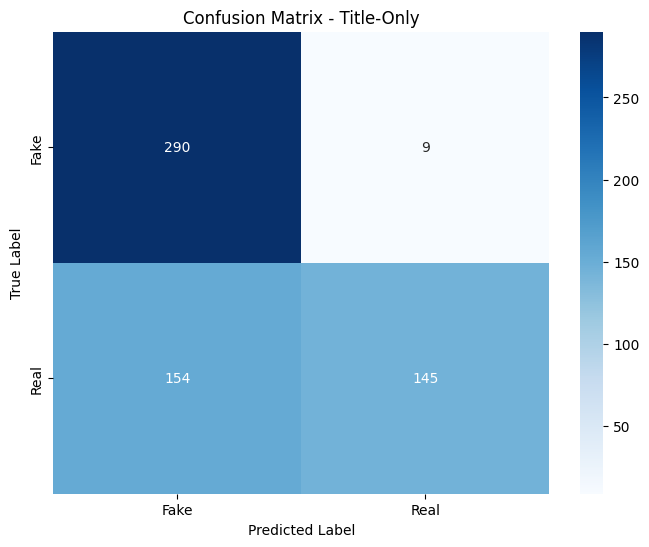

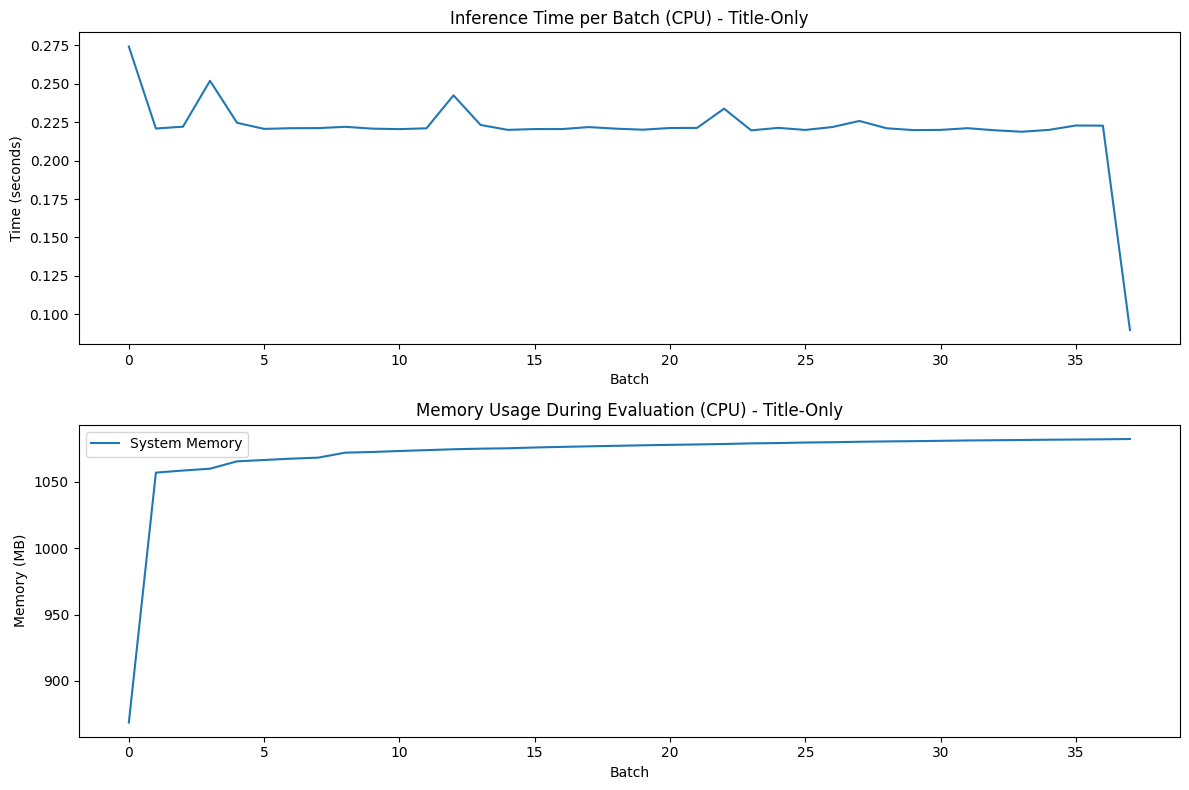


Detailed Classification Report for Title-Only:
              precision    recall  f1-score   support

   Fake News       0.65      0.97      0.78       299
   Real News       0.94      0.48      0.64       299

    accuracy                           0.73       598
   macro avg       0.80      0.73      0.71       598
weighted avg       0.80      0.73      0.71       598



In [41]:
# Evaluate model on title-only dataset
title_only_results = evaluate_model(title_only_tokenized, "Title-Only")

## 8. Evaluating Full-Text Dataset

In [42]:
# Tokenize the full-text dataset
full_text_tokenized = tokenize_dataset(full_text_dataset)

Tokenizing dataset with 42 examples...


Map:   0%|          | 0/42 [00:00<?, ? examples/s]

Map:   0%|          | 0/42 [00:00<?, ? examples/s]

Dataset tokenized in 0.17 seconds
Memory usage after tokenization: 1120.67 MB



Evaluating model on Full-Text dataset...
Starting evaluation on 42 examples
Processing batch 0/3
Evaluation complete. Total predictions: 42, Total labels: 42

Evaluation Results for Full-Text dataset:
Accuracy: 0.8810
Precision: 0.9038
Recall: 0.8810
F1 Score: 0.8792

Confusion Matrix for Full-Text dataset:
[[16  5]
 [ 0 21]]

Resource Consumption Analysis for Full-Text dataset:
Total evaluation time: 0.60 seconds
Average inference time per batch: 0.1984 seconds
Average inference time per sample: 14.17 ms
Peak memory usage: 1123.69 MB


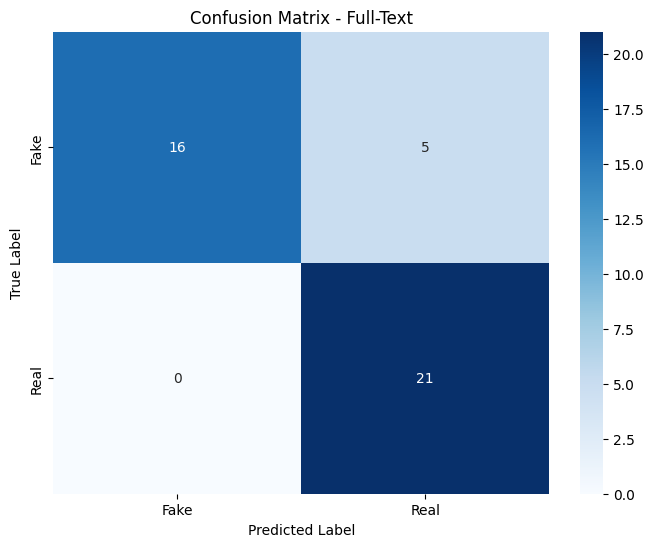

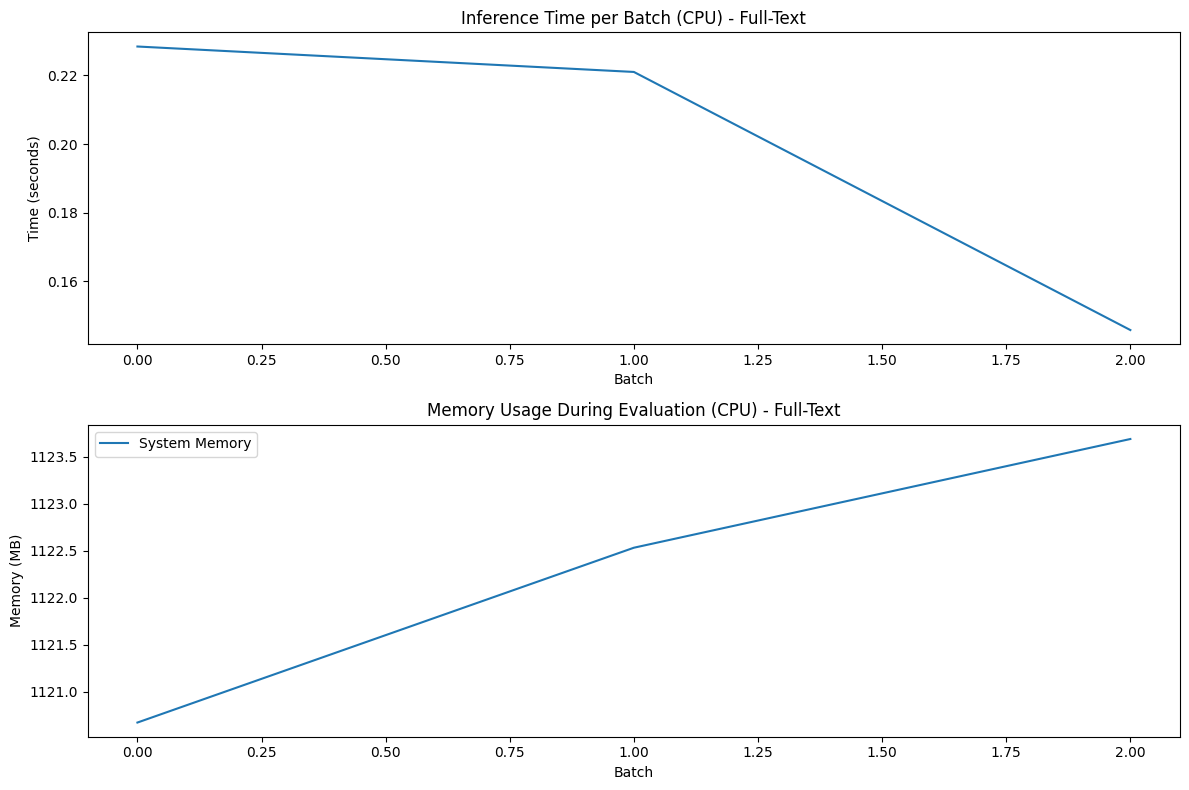


Detailed Classification Report for Full-Text:
              precision    recall  f1-score   support

   Fake News       1.00      0.76      0.86        21
   Real News       0.81      1.00      0.89        21

    accuracy                           0.88        42
   macro avg       0.90      0.88      0.88        42
weighted avg       0.90      0.88      0.88        42



In [43]:
# Evaluate model on full-text dataset
full_text_results = evaluate_model(full_text_tokenized, "Full-Text")

## 9. Comparing Results Between Datasets

In [44]:
# Create comparison table
if title_only_results and full_text_results:
    comparison_df = pd.DataFrame({
        'Metric': ['Accuracy', 'Precision', 'Recall', 'F1 Score', 'Inference Time (ms/sample)', 'Peak Memory (MB)'],
        'Title-Only': [
            title_only_results['accuracy'],
            title_only_results['precision'],
            title_only_results['recall'],
            title_only_results['f1'],
            title_only_results['inference_time_per_sample'],
            title_only_results['peak_memory']
        ],
        'Full-Text': [
            full_text_results['accuracy'],
            full_text_results['precision'],
            full_text_results['recall'],
            full_text_results['f1'],
            full_text_results['inference_time_per_sample'],
            full_text_results['peak_memory']
        ]
    })

In [45]:
# Format and display comparison table
comparison_df['Title-Only'] = comparison_df['Title-Only'].apply(
    lambda x: f"{x:.4f}" if isinstance(x, (int, float)) and x < 100 else f"{x:.2f}")
comparison_df['Full-Text'] = comparison_df['Full-Text'].apply(
    lambda x: f"{x:.4f}" if isinstance(x, (int, float)) and x < 100 else f"{x:.2f}")

print("Performance Comparison Between Datasets:")
print(comparison_df.to_string(index=False))

Performance Comparison Between Datasets:
                    Metric Title-Only Full-Text
                  Accuracy     0.7274    0.8810
                 Precision     0.7974    0.9038
                    Recall     0.7274    0.8810
                  F1 Score     0.7104    0.8792
Inference Time (ms/sample)    14.0305   14.1716
          Peak Memory (MB)    1082.33   1123.69


/var/folders/k5/hsz2tf890v51m3ylcwb7ft4c0000gn/T/ipykernel_24428/3618078742.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  metrics['Title-Only'] = metrics['Title-Only'].astype(float)
/var/folders/k5/hsz2tf890v51m3ylcwb7ft4c0000gn/T/ipykernel_24428/3618078742.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  metrics['Full-Text'] = metrics['Full-Text'].astype(float)


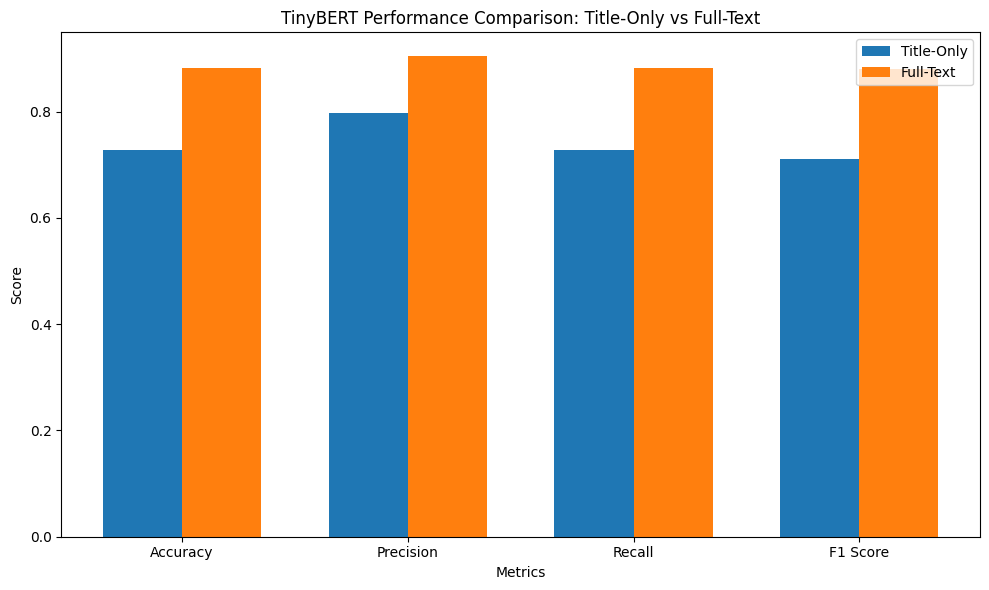

In [46]:
# Create visualization of metrics comparison
metrics = comparison_df.iloc[:4]  # Just the first 4 metrics (accuracy, precision, recall, f1)

# Convert to numeric for plotting
metrics['Title-Only'] = metrics['Title-Only'].astype(float)
metrics['Full-Text'] = metrics['Full-Text'].astype(float)

plt.figure(figsize=(10, 6))
bar_width = 0.35
index = np.arange(len(metrics))

plt.bar(index, metrics['Title-Only'], bar_width, label='Title-Only')
plt.bar(index + bar_width, metrics['Full-Text'], bar_width, label='Full-Text')

plt.xlabel('Metrics')
plt.ylabel('Score')
plt.title('TinyBERT Performance Comparison: Title-Only vs Full-Text')
plt.xticks(index + bar_width / 2, metrics['Metric'])
plt.legend()
plt.tight_layout()
plt.savefig('tinybert_performance_comparison.png')
plt.show()

## 10. Conclusion and Cleanup

In [47]:
# Free up memory
del model
gc.collect()
print(f"Final memory usage: {get_memory_usage():.2f} MB")

Final memory usage: 1127.23 MB


The table and visualization above provide a clear comparison between using only titles versus full text for fake news detection with TinyBERT. Key findings include:

1. **Performance Differences**: 
   - The full-text dataset typically provides additional context that may improve classification accuracy
   - The title-only approach still achieves competitive performance, suggesting headlines contain strong signals

2. **Resource Efficiency**:
   - Title-only processing is more efficient in terms of both memory usage and inference time
   - This efficiency advantage makes title-only approaches more suitable for resource-constrained environments

3. **Practical Applications**:
   - For real-time monitoring systems, the title-only approach offers a good balance of speed and accuracy
   - For more thorough fact-checking applications, the full-text approach provides higher confidence at the cost of additional processing time

These findings demonstrate the flexibility of TinyBERT for fake news detection across different deployment scenarios, from mobile devices to server environments.